<a href="https://colab.research.google.com/github/BonaventureR/CNN-AnimalTracks/blob/gpu-cnn-linux/Animal_Track_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Animal Track Classification With CNN
### ITCS 4156, Spring 2020
#### Sara Ashcraft, James Black, Debabrata Das, Bonaventure Raj

### Objective
We will train a CNN to classify animal tracks based on the taxonomic rank of order. If successful, our results would be useful for wildlife conservation. We will be referencing work done by individuals from the Dogs vs. Cats Kaggle challenge linked below:

https://www.kaggle.com/c/dogs-vs-cats

This will allow us to jumpstart our project by building off of others' work on a similar problem. Let's start by preparing our data.

### Data
Our dataset will be composed of images of animal tracks. We collected this data by web scraping the following site:

http://www.naturetracking.com/mammal-tracks/#/

After collecting the data, we grouped the images by the order of the species that the track images belonged to. We chose to classify by order, as opposed to more specific classifications like family, genus, or species, because of the amount of data available. Grouping by a more specific classification would mean that some classes would not have enough data.

In [0]:
import cv2 as cv
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
from copy import deepcopy as copy
import tensorflow as tf
from tensorflow import keras
import os
from sklearn.model_selection import train_test_split


In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
cd "/content/drive/My Drive/images"

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-47-5d83054a9495>", line 1, in <module>
    get_ipython().magic('cd "/content/drive/My Drive/images"')
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2160, in magic
    return self.run_line_magic(magic_name, magic_arg_s)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2081, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-91>", line 2, in cd
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/magic.py", line 188, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/magics/osm.py", line 288, in cd
    oldcwd = py3compat.getcwd()
OSError: [Errno 107] Transport endpoint is not connected

During handling of th

OSError: ignored

In [0]:
path = os.getcwd()

In [0]:
# google colab dir image load
labels = []
images = []
plotting_images = []


for folder in os.listdir(path):
      order_path = os.listdir(str(os.getcwd()) + "/" + folder)
      for subfolder in order_path:
          if subfolder != 'c':
            image_path = os.listdir(str(os.getcwd()) + "/" + folder + "/" + subfolder)
            for image in image_path:
                if image != 'c':
                  labels.append(folder)
                  plotting_images.append(str(os.getcwd()) + "/" + folder + "/" + subfolder + "/" + image)
                  images.append(image)

df = pd.DataFrame({'image':images, 'order':labels, 'path':plotting_images})
df

,image,order,path
0,1.thumbnail,Artiodactyla,/content/drive/My Drive/images/Artiodactyla/El...
1,0.thumbnail,Artiodactyla,/content/drive/My Drive/images/Artiodactyla/El...
2,6.thumbnail,Artiodactyla,/content/drive/My Drive/images/Artiodactyla/El...
3,4.thumbnail,Artiodactyla,/content/drive/My Drive/images/Artiodactyla/El...
4,2.thumbnail,Artiodactyla,/content/drive/My Drive/images/Artiodactyla/El...
...,...,...,...
636,4.thumbnail,Perissodactyla,/content/drive/My Drive/images/Perissodactyla/...
637,2.thumbnail,Perissodactyla,/content/drive/My Drive/images/Perissodactyla/...
638,0.thumbnail,Perissodactyla,/content/drive/My Drive/images/Perissodactyla/...
639,1.thumbnail,Perissodactyla,/content/drive/My Drive/images/Perissodactyla/...


In [0]:
# path = os.listdir("/content/gdrive/My Drive/images")
# labels = []
# images = []
# plotting_images = []


# for folder in path:
#     order_path = os.listdir("/images/" + folder)
#     for subfolder in order_path:
#         image_path = os.listdir("/images/" + folder + "/" + subfolder)
#         for image in image_path:
#             labels.append(folder)
#             plotting_images.append('/images/' + folder + "/"+ subfolder + "/" + image)
#             images.append(image)

# df = pd.DataFrame({'image':images, 'order':labels, 'path':plotting_images})
# df

In [0]:
print(len(df['image']))
num_order = len(df['order'].unique())
df['order'].unique()

641


array(['Artiodactyla', 'Lagomorpha', 'Rodentia', 'Carnivora',
       'Perissodactyla'], dtype=object)

Let us take a look at a random sample of our data in order to determine what preprocessing should be done. First, we will want to separate our images and their labels. Then, we will plot.

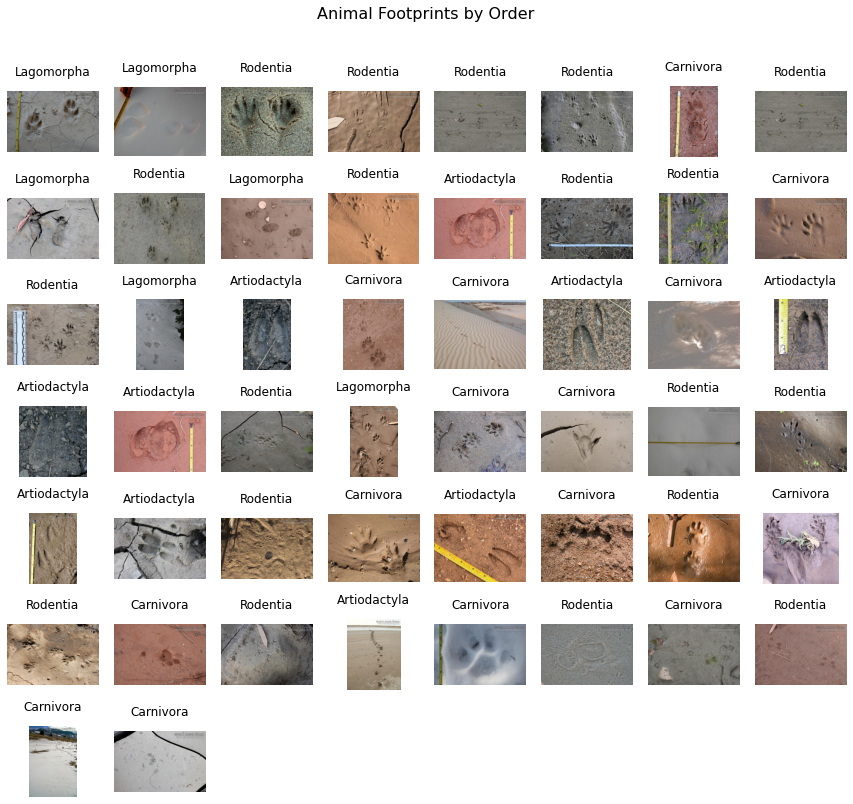

In [0]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import IPython.display as ipd

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.titlepad'] = 15

# Separate images and labels
X = df[['image']].values.copy()
y = df[['order']].values.copy()
plt_y = df[['path']].values.copy()

# Random indexes
N = df.shape[0]
randIdxs = np.random.randint(N, size=50)

# Visualize
plt.figure(figsize=(12,12))
plt.suptitle("Animal Footprints by Order" , size=16, y=1.05)
nr = int(np.ceil(np.sqrt(randIdxs.size)))

for i in range(randIdxs.size):
    plt.subplot(nr, nr, 1 + i)
    path = plt_y[randIdxs[i]][0]
    img = mpimg.imread(path)
    plt.imshow(img, cmap="binary")
    plt.title(y[randIdxs[i]][0])
    plt.axis("off")
plt.tight_layout()

In [0]:
labels = {
    'Artiodactyla' : 0,
    'Carnivora' : 1,
    'Lagomorpha' : 2,
    'Perissodactyla' : 3,
    'Rodentia' : 4
}
conv_back = {v:k for k, v in labels.items()}

In [0]:
labels, conv_back

({'Artiodactyla': 0,
  'Carnivora': 1,
  'Lagomorpha': 2,
  'Perissodactyla': 3,
  'Rodentia': 4},
 {0: 'Artiodactyla',
  1: 'Carnivora',
  2: 'Lagomorpha',
  3: 'Perissodactyla',
  4: 'Rodentia'})

In [0]:
Xs = []
for img in plt_y:
    img = mpimg.imread(path)
    Xs.append(img)

In [0]:
Ys = df.replace({'order':labels})['order'].values
Ys.shape

(641,)

In [0]:
Xs = np.array(Xs)
Xs.shape

(641, 423, 636, 3)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(Xs, Ys, test_size=0.4)

In [0]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((384, 423, 636, 3), (257, 423, 636, 3), (384,), (257,))

### Preprocesing

While we were scraping the images in, we processed all the images to have the same dimensions so that it would be easier to pass into the convultional net. We can see below that the dimensions are (636,424,3) where 636,424, and 3 represents the height width and number of channels, respectively.

In [0]:
preprocess = []

for i in range(len(df['path'])):
    img = mpimg.imread(df['path'][0])
    preprocess.append(img.shape)
print(preprocess[0])
assert(len(preprocess) == len(df['path']))
# checking if all values == (636,424,3)
print("All values are of size", str(preprocess[0]) + "?:", all(i==(636,424,3) for i in preprocess))

(636, 424, 3)
All values are of size (636, 424, 3)?: True


Below we standardize the data, as we saw above the color disperancies of the background are very evident. However, it isn't the background that we are concerned with but the footprints. If we standardize the data so that all the values then it will allow us to better gauge the features and landmarks rather than the trees and branches in the images.

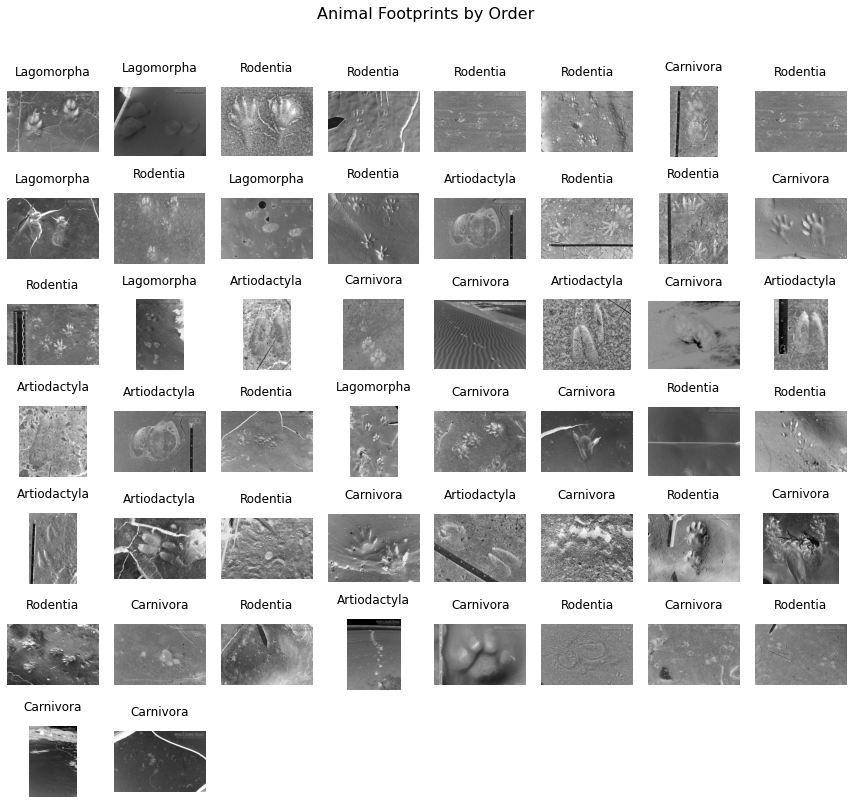

In [0]:
# Standardize
norm_images = []

for i in range(N):
    path = plt_y[i][0]
    img = mpimg.imread(path)
    img = np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])
    img = np.asarray(img).astype('float32')
    norm_img = (img-img.mean())/img.std()
    norm_images.append(norm_img)

# Visualize
plt.figure(figsize=(12,12))
plt.suptitle("Animal Footprints by Order" , size=16, y=1.05)
nr = int(np.ceil(np.sqrt(randIdxs.size)))

for i in range(randIdxs.size):
    plt.subplot(nr, nr, 1 + i)
    plt.imshow(norm_images[randIdxs[i]], cmap="binary")
    plt.title(y[randIdxs[i]][0])
    plt.axis("off")
plt.tight_layout()

# Convolutional Neural Net (CNN)

Convolutional Neural Nets or CNN's for short, are an effective way to conduct image processing and signal processing. CNN's operate more structurally allowing for the high-level features to be given more weight and the noise less weight. Traditional thought processes might lead us to believe that simply taking the image dimensions i.e (4,4) and flattening it i.e (16,1) and passing that into a Multi-level preceptron for classification purposes would serve our needs. However, this method seems to only show images that are similar but has no real metric for analyzing spatial and temporal dependencies (i.e pixel dependencies across the whole image). Whereas, with filters, kernels and pooling layers conv2d nets excel in this area.

<img src="./conv2d_kernel&filter.png"/>

<center> 
    src:  https://towardsdatascience.com/types-of-convolution-kernels-simplified-f040cb307c37 
</center>
<br/>
<br/>
Terminology:

- Kernels - The 2D array of weights associated with an index/location for the filter.

- Filters - The 3D structure of multiple kernels stacked together (each being a channel of input (i.e H X W X CHANNEL)


In [0]:
n_shape = X_train.shape[1:]
n_filters = 32
num_outputs = num_order
kernels = (3,3)

In [0]:
cnn = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=n_filters, kernel_size=kernels, activation='relu', input_shape=n_shape),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Conv2D(filters=(n_filters*2), kernel_size=kernels, activation='relu'),
        tf.keras.layers.MaxPooling2D((3,3)),
        tf.keras.layers.Conv2D(filters=(n_filters*2), kernel_size=kernels, activation='relu'),
        tf.keras.layers.MaxPooling2D((3,3)),
        tf.keras.layers.Conv2D(filters=(n_filters*2), kernel_size=kernels, activation='relu'),
        tf.keras.layers.MaxPooling2D((3,3)),
        tf.keras.layers.Conv2D(filters=(n_filters*2), kernel_size=kernels, activation='relu'),
        tf.keras.layers.MaxPooling2D((3,3)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(num_outputs, activation="softmax")
    ])

In [0]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 421, 634, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 210, 317, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 208, 315, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 69, 105, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 67, 103, 64)       36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 34, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 32, 64)        3

In [0]:
cnn.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [0]:
history = cnn.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
12/12 [==============================] - 151s 13s/step - loss: 1.7780 - accuracy: 0.1224 - val_loss: 1.7868 - val_accuracy: 0.1323
Epoch 2/10
12/12 [==============================] - 153s 13s/step - loss: 1.7824 - accuracy: 0.1224 - val_loss: 1.7868 - val_accuracy: 0.1323
Epoch 3/10
12/12 [==============================] - 151s 13s/step - loss: 1.7824 - accuracy: 0.1224 - val_loss: 1.7868 - val_accuracy: 0.1323
Epoch 4/10
12/12 [==============================] - 151s 13s/step - loss: 1.7824 - accuracy: 0.1224 - val_loss: 1.7868 - val_accuracy: 0.1323
Epoch 5/10
12/12 [==============================] - 152s 13s/step - loss: 1.7824 - accuracy: 0.1224 - val_loss: 1.7868 - val_accuracy: 0.1323
Epoch 6/10
12/12 [==============================] - 153s 13s/step - loss: 1.7824 - accuracy: 0.1224 - val_loss: 1.7868 - val_accuracy: 0.1323
Epoch 7/10
12/12 [==============================] - 151s 13s/step - loss: 1.7824 - accuracy: 0.1224 - val_loss: 1.7868 - val_accuracy: 0.1323
Epoch 

### References
https://www.kaggle.com/uysimty/keras-cnn-dog-or-cat-classification